# Kullback-Leibler Divergences Method to Analyze Multi-armed Bandits

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from cvxpy import *
%matplotlib inline

In [437]:
class KLModel:
    def __init__(self, processSpace):
        self.processSpace = processSpace
        self.decisionTime = 0 
        self.visitList = np.ones(self.processSpace) # count visits to each machines
        self.totalCost = 0
        self.costMat = [] #store all the costs for every decisions        
        self.costAveList = np.zeros(self.processSpace)
    
    def rewardSim(self,candidates):
        costList = np.zeros(self.processSpace)
        for i in candidates:
            costList[i] = np.random.binomial(1,(i+1)/(self.processSpace+1))
        self.costMat.append(costList)
        
    def initStep(self):
        self.rewardSim(range(self.processSpace))
        self.choice = self.costMat[-1].argmax()
        self.costAveList = self.costMat[-1]
        self.visitList[self.choice] += 1
        self.decisionTime += self.processSpace
        self.totalCost += self.costMat[-1][self.choice]
        self.costAveList = self.costMat[0]
    
    def boundFunc(self):
        return np.log((np.e*self.decisionTime)*np.log(np.e*self.decisionTime)**(3))
    
    def updateStep(self):
        self.decisionTime += 1
        B_List = []
        for i in range(self.processSpace):
            B_List.append(self.maxCalculate(i))
        self.choice = np.argmax(B_List)
        self.visitList[self.choice] += 1
        costList = np.zeros(self.processSpace)
        costList[self.choice] = np.random.binomial(1,(self.choice+1)*0.1)
        self.costMat.append(costList)
        summedCost = np.sum(np.array(self.costMat),0)
        self.costAveList = summedCost/self.visitList     
        
    def visitBoundCalculation(self):
        b1 = 4*(self.upperBound**2)/((self.processSpace-np.arange(self.processSpace)-1)**2)
        b2 = self.explorationFactor*np.log(self.decisionTime)
        b3 = 3/2+1/2/(self.explorationFactor-1)
        self.visitBound = b1*b2+b3
    
    def maxCalculate(self,i):
        x = Variable(1)
        objective = Minimize(x)
        constraints = [0 <= x, x <= 1, kl_div(self.costAveList[i],x) <= self.boundFunc()]
        prob = Problem(objective, constraints)
        prob.solve()  # Returns the optimal value.
        return(prob.value)

In [438]:
klmodel = KLModel(9)
klmodel.initStep()
print(klmodel.visitList)
for i in range(1000):
    klmodel.updateStep()

[ 1.  1.  2.  1.  1.  1.  1.  1.  1.]


[   0.    0.    1.    0.    2.    1.    6.    1.  888.]
[   1.    1.    3.    1.    4.    2.    7.    2.  989.]


<Container object of 9 artists>

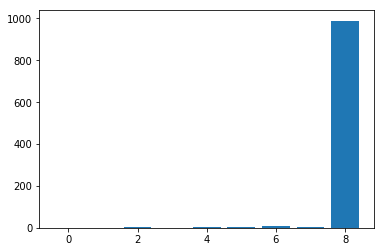

In [439]:
print(np.sum(np.array(klmodel.costMat),0))
print(klmodel.visitList)
plt.bar(range(klmodel.processSpace),klmodel.visitList)

In [441]:
regret = klmodel.decisionTime*klmodel.processSpace/(10+klmodel.processSpace)-np.sum(np.array(klmodel.costMat))
print(regret)

-421.052631579


In [442]:
totalCost = np.sum(np.array(klmodel.costMat))
print(totalCost)

899.0
